# Comparison between different models for the Kaggle challenge "SETI Breakthrough Listen" 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import albumentations as A
from efficientnet_pytorch import model as enet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import codecs
from PIL import Image
import copy

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### Load the Train labels and create a mapping between the id and the path to the image

In [4]:
df_train=pd.read_csv('./train_labels.csv')
df_train.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


In [5]:
df_train['img_path']=df_train['id'].apply(lambda x:f'./train/{x[0]}/{x}.npy')
df_train.head()

,id,target,img_path
0,0000799a2b2c42d,0,./train/0/0000799a2b2c42d.npy
1,00042890562ff68,0,./train/0/00042890562ff68.npy
2,0005364cdcb8e5b,0,./train/0/0005364cdcb8e5b.npy
3,0007a5a46901c56,0,./train/0/0007a5a46901c56.npy
4,0009283e145448e,0,./train/0/0009283e145448e.npy


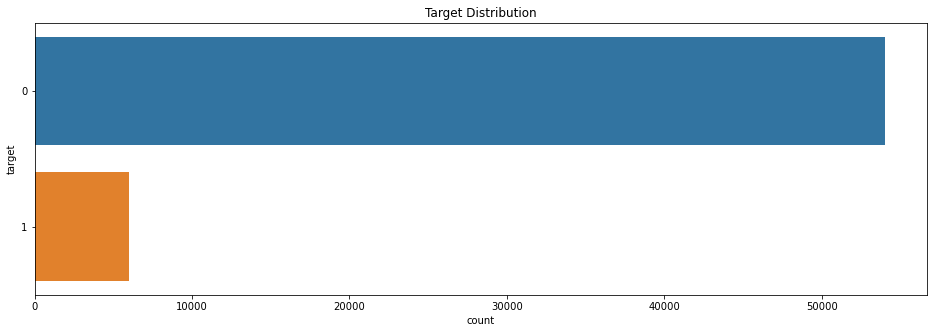

In [6]:
plt.figure(figsize=(16, 5))
sn.countplot(y="target", data=df_train)
plt.title("Target Distribution");

### Define the Dataset and the Neural Network classes

In [7]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets, augment=None): 
        self.image_paths = image_paths
        self.targets = targets
        self.augment = augment
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = np.load(self.image_paths[item]).astype(float)
        
        targets = self.targets[item]
        
        # Image Preprocessing: Stack vertically, transpose and resize to 512 x 512 
        
        image = np.vstack(image).transpose((1, 0))
        img_pl = Image.fromarray(image).resize((512, 512), resample=Image.BICUBIC)
        image = np.array(img_pl)
            
        # Augmentation
        if self.augment:
            image = self.augment(image=image)['image']
                
        return {
            "image": torch.from_numpy(image).unsqueeze(dim=0),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [8]:
class enetv2(nn.Module):
    def __init__(self, backbone, pretrained=False, out_dim=1):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        if pretrained:
            self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1Norm = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=3, bias=False)
        self.poolNorm = nn.MaxPool2d(2, 2)
        self.conv2Norm = nn.Conv2d(32, 3, kernel_size=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.conv1Norm(x)
        x = self.poolNorm(x)
        x = self.conv2Norm(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

### Define train and evaluation function

In [9]:
def train(data_loader, model, optimizer, device):
    
    model.train()
    running_loss = 0
    i = 0
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        i += 1
        inputs = data["image"]
        targets = data['targets']
        
        # Cast
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = model(inputs) # Output Weights
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)) # Loss calculation
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    return running_loss / i
        
def evaluate(data_loader, model, device):
    model.eval() # Sets to evaluation mode
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        running_loss = 0
        i = 0
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            
            running_loss += nn.BCEWithLogitsLoss()(output, targets.view(-1, 1)).item()
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets, running_loss / i

In [13]:
baseline_name = ['efficientnet-b1', 'efficientnet-b3', 'efficientnet-b5'] # Neural Networks to use
pretrained_model = {
    baseline_name[0]: './checkpoint/efficientnet-b1-dbc7070a.pth', # Pretrained models
    baseline_name[1]: './checkpoint/efficientnet-b3-c8376fa2.pth',
    baseline_name[2]: './checkpoint/efficientnet-b5-586e6cc6.pth'
}
models = []
device = "cuda"
Batch_Size = 16
X = df_train.img_path.values
Y = df_train.target.values
skf = StratifiedKFold(n_splits=5) # Cross Validation 5-fold, mehrschichtig (stratified)
# -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)

starter_models = [enetv2(baseline_name[0], pretrained=True, out_dim=1),
                          enetv2(baseline_name[1], pretrained=True, out_dim=1),
                          enetv2(baseline_name[2], pretrained=True, out_dim=1)]

names = ['efficientnet-b1', 'efficientnet-b3', 'efficientnet-b5']

epochs = 5
train_losses = [[[] for i in range(5)] for i in names]
valid_losses = [[[] for i in range(5)] for i in names]
aurocs = [[[] for i in range(5)] for i in names]

it = 0

In [14]:
#create log file
codecs.open('results.log', 'w+');

In [58]:
for model in starter_models:
    best_roc_auc = 0
    fold = 0
    for train_index, test_index in skf.split(X, Y):
        
        train_augment = A.Compose([
                        A.VerticalFlip(p=0.5),
                        # CoarseDropout because Cutout is deprecated - works the same way
                        A.CoarseDropout(max_height=int(512 * 0.1), max_width=int(512 * 0.1), max_holes=5, p=0.5),
                        ])
        
        starter_models = [enetv2(baseline_name[0], pretrained=True, out_dim=1),
                          enetv2(baseline_name[1], pretrained=True, out_dim=1),
                          enetv2(baseline_name[2], pretrained=True, out_dim=1)]
        
        model = starter_models[it]
        model.to(device)

        train_images, valid_images = X[train_index], X[test_index]
        train_targets, valid_targets = Y[train_index], Y[test_index]

        train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets, augment=train_augment)
        valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets, augment=None)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        
        row = 0
        last_loss = 0
        train_loss = 10
        
        
        for epoch in range(epochs):
            if epoch == 4:
                for param_group in optimizer.param_groups:
                    param_group["lr"] = 1e-4
                    
            train_loss = train(train_loader, model, optimizer, device=device)
            predictions, valid_targets, valid_loss = evaluate(valid_loader, model, device=device)
            roc_auc = metrics.roc_auc_score(valid_targets, predictions)
            
            train_losses[it][fold].append(train_loss) 
            valid_losses[it][fold].append(valid_loss)
            aurocs[it][fold].append(roc_auc)
            
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc

            print(f"Model={names[it]}, Fold {fold}: Epoch={epoch}, Train Loss={train_loss}, Validation Loss={valid_loss}, Validation ROC AUC={roc_auc}")
            with codecs.open('results.log', 'a') as up:
                up.write(f"Model={names[it]}, Fold={fold}, Epoch={epoch}, Valid ROC AUC={roc_auc}/{best_roc_auc}\n")

            if roc_auc > best_roc_auc:
                print(f"New best AUROC: Model={names[it]}, Fold {fold}: Epoch={epoch}, Validation ROC AUC={roc_auc}")
                torch.save(model.state_dict(), baseline_name + '-' + str(fold) + '-' + str(epoch) + '.pt')
                best_roc_auc = roc_auc

        models.append(model)
        fold += 1
    it += 1
    
print('finished')

Training:   0%|                                                                                                                                                                                    | 0/3000 [00:00<?, ?it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/gala/.conda/envs/seti/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/gala/.conda/envs/seti/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/gala/.conda/envs/seti/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_3946/3684302831.py", line 13, in __getitem__
    image = np.load(self.image_paths[item]).astype(float)
  File "/home/gala/.conda/envs/seti/lib/python3.7/site-packages/numpy/lib/npyio.py", line 417, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
FileNotFoundError: [Errno 2] No such file or directory: './train/f/f5d07dfaac96ec7.npy'


In [ ]:
np.save('aurocs.npy', np.array(aurocs))

In [49]:
#aurocs = np.load('aurocs.npy', allow_pickle=True)
aurocs

array([[[0.49895185, 0.49887076, 0.5010811 , 0.49621725, 0.50140552,
         0.52072762, 0.49761038, 0.51568684, 0.49936026, 0.5052787 ],
        [0.74703654, 0.80050552, 0.82432828, 0.81856254, 0.82000247,
         0.84202099, 0.85266265, 0.85533665, 0.85646975, 0.85598102],
        [0.78519255, 0.81999248, 0.81689101, 0.83545671, 0.8429554 ,
         0.83363831, 0.85673819, 0.85735448, 0.86106076, 0.8627466 ],
        [0.77145228, 0.79541651, 0.81720432, 0.82915602, 0.83143356,
         0.83350721, 0.85733391, 0.85895285, 0.86285394, 0.86541952],
        [0.75784117, 0.80310571, 0.82233912, 0.81935463, 0.82314267,
         0.83326929, 0.85275637, 0.85745312, 0.85854329, 0.86105818]],

       [[0.4909995 , 0.49349047, 0.50157095, 0.49491701, 0.50432191,
         0.49293889, 0.49117191, 0.50347867, 0.50967407, 0.49226346],
        [0.49898561, 0.4916588 , 0.50702122, 0.51363935, 0.49204734,
         0.49595667, 0.51356975, 0.50885571, 0.50474934, 0.5077848 ],
        [0.71422539, 0.80

In [52]:
#ab = np.load('train_losses.npy', allow_pickle=True)

#aurocs_mean = copy.deepcopy(aurocs)
#aurocs_max = copy.deepcopy(aurocs)

aurocs_mean = np.zeros((3,5))
aurocs_max = np.zeros((3,5))


for i in range(3):
    for j in range(5):
        aurocs_mean[i][j] = np.mean(aurocs[i][j])
        aurocs_max[i][j] = np.max(aurocs[i][j])

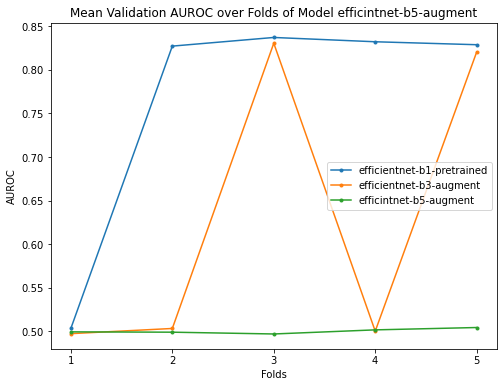

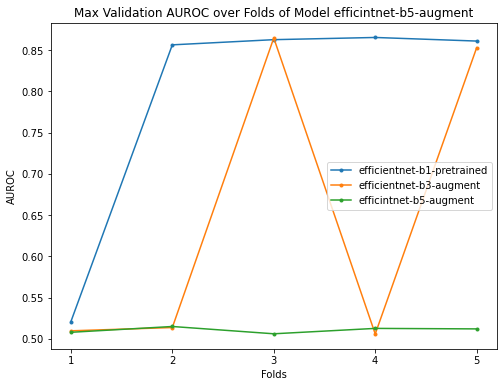

In [55]:
plt.figure(figsize=(8,6))
for j in range(3):
    plt.plot(range(1, len(aurocs[j]) + 1), aurocs_mean[j], label=names[j], marker=".")
plt.xlabel("Folds")
plt.ylabel("AUROC")
plt.xticks(np.arange(1, len(aurocs[j]) + 1, step=1))
plt.legend()
plt.title(f"Mean Validation AUROC over Folds of Model {names[j]}");

plt.figure(figsize=(8,6))
for j in range(3):
    plt.plot(range(1, len(aurocs[j]) + 1), aurocs_max[j], label=names[j], marker=".")
plt.xlabel("Folds")
plt.ylabel("AUROC")
plt.xticks(np.arange(1, len(aurocs[j]) + 1, step=1))
plt.legend()
plt.title(f"Max Validation AUROC over Folds of Model {names[j]}");



In [56]:
print(f"Batch Size {Batch_Size}")
for i in range(len(aurocs)):
    print(f"\nModel {names[i]}")
    for j in range(5):
        print(f"Fold {j}, mean AUROC: {np.mean(aurocs[i][j])}, best AUROC: {np.max(aurocs[i][j])}")

Batch Size 16

Model efficientnet-b1-pretrained
Fold 0, mean AUROC: 0.5035190277777778, best AUROC: 0.5207276234567901
Fold 1, mean AUROC: 0.8272906404320988, best AUROC: 0.8564697530864198
Fold 2, mean AUROC: 0.837202650462963, best AUROC: 0.8627466049382716
Fold 3, mean AUROC: 0.832273013117284, best AUROC: 0.8654195216049383
Fold 4, mean AUROC: 0.8288863541666667, best AUROC: 0.8610581790123457

Model efficientnet-b3-augment
Fold 0, mean AUROC: 0.4974826851851851, best AUROC: 0.5096740740740741
Fold 1, mean AUROC: 0.5034268595679011, best AUROC: 0.5136393518518518
Fold 2, mean AUROC: 0.8305720563271605, best AUROC: 0.8647927469135801
Fold 3, mean AUROC: 0.5003324189814815, best AUROC: 0.5058332561728396
Fold 4, mean AUROC: 0.8205029166666666, best AUROC: 0.8530609182098765

Model efficintnet-b5-augment
Fold 0, mean AUROC: 0.49952995756172835, best AUROC: 0.5078660108024691
Fold 1, mean AUROC: 0.49916410879629636, best AUROC: 0.5149051697530864
Fold 2, mean AUROC: 0.49711257330246916